#  Segmentación de Clientes con K-means  
### *Mall Customers Dataset*

##  Introducción
En este ejercicio aplicaremos **Machine Learning no supervisado** para resolver un problema clásico de análisis de clientes: **segmentar a los usuarios de un centro comercial** según sus características demográficas y de comportamiento.

La segmentación de clientes es una técnica fundamental en marketing, ventas y analítica de negocio, ya que permite identificar **grupos con patrones similares**, y entender su comportamiento para diseñar estrategias más efectivas.

El algoritmo principal que utilizaremos es **K-means**, uno de los métodos más populares para clustering debido a su simplicidad, velocidad y capacidad para encontrar estructuras en datos numéricos.

El dataset que analizaremos proviene del conocido *Mall Customers Dataset*, e incluye información como:

-  **Género**  
-  **Edad**  
-  **Ingreso anual (Annual Income)**  
-  **Puntaje de gasto (Spending Score)**  

Nuestro objetivo será identificar grupos naturales de clientes —por ejemplo, clientes de alto gasto, clientes jóvenes, clientes con bajo ingreso, etc.— usando técnicas de aprendizaje no supervisado.

---

##  Objetivos del Proyecto

1. **Explorar** el dataset y analizar sus variables principales.  
2. **Preprocesar** los datos: limpieza, normalización y selección de variables relevantes.  
3. Determinar el número óptimo de clusters mediante:  
   - Método del Codo (*Elbow Method*)  
   - Silhouette Score  
4. **Aplicar K-means** para segmentar clientes.  
5. **Visualizar los clusters** usando:
   - Gráficos 2D  
   - Gráficos 3D interactivos (Plotly)  
6. **Interpretar** las características de cada segmento de clientes.  
7. Preparar conclusiones y recomendaciones basadas en el análisis.




#Librerías

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")


In [2]:
# Cargar archivo CSV
datos = pd.read_csv("/content/Mall_Customers.csv")
datos.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# Vista general de los datos
datos.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# Estadísticas descriptivas
datos.describe()



,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
# Revisar valores nulos
datos.isnull().sum()


,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


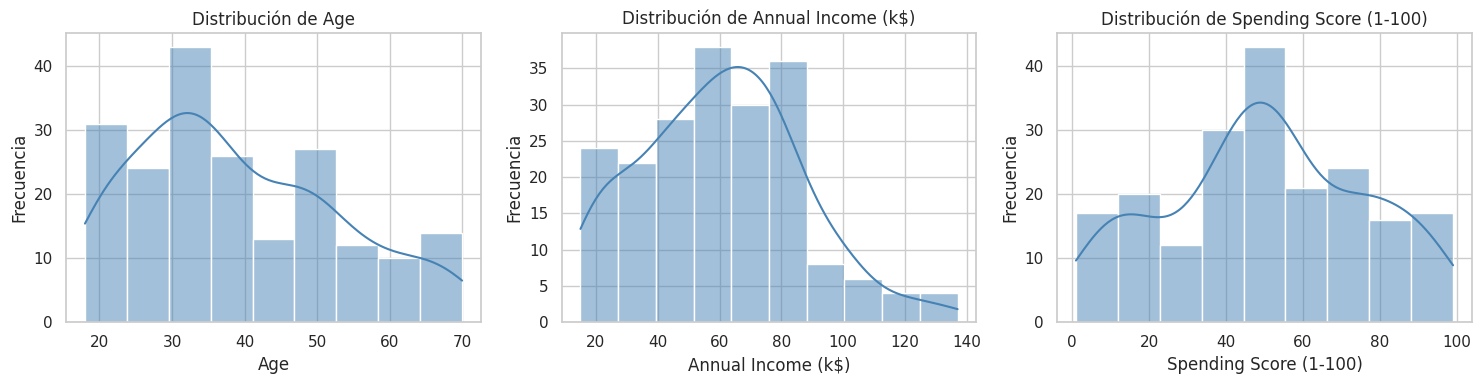

In [7]:
# ============================================
# Distribución de variables numéricas
# ============================================

variables_numericas = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

plt.figure(figsize=(15, 4))

for i, col in enumerate(variables_numericas, 1):
    plt.subplot(1, 3, i)
    sns.histplot(datos[col], kde=True, color='steelblue')
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


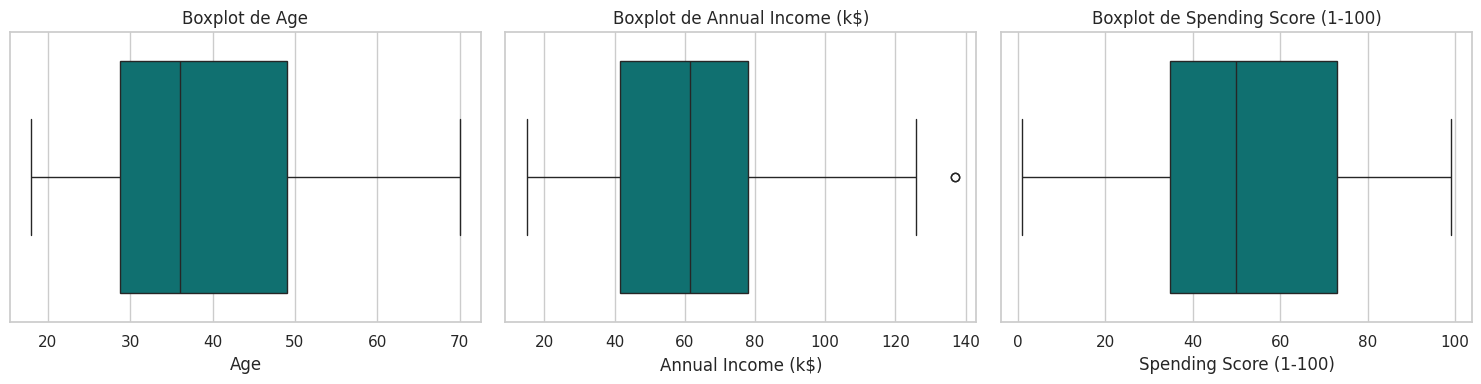

In [8]:

# Boxplots para detectar valores atípicos


plt.figure(figsize=(15, 4))

for i, col in enumerate(variables_numericas, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=datos[col], color='teal')
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()


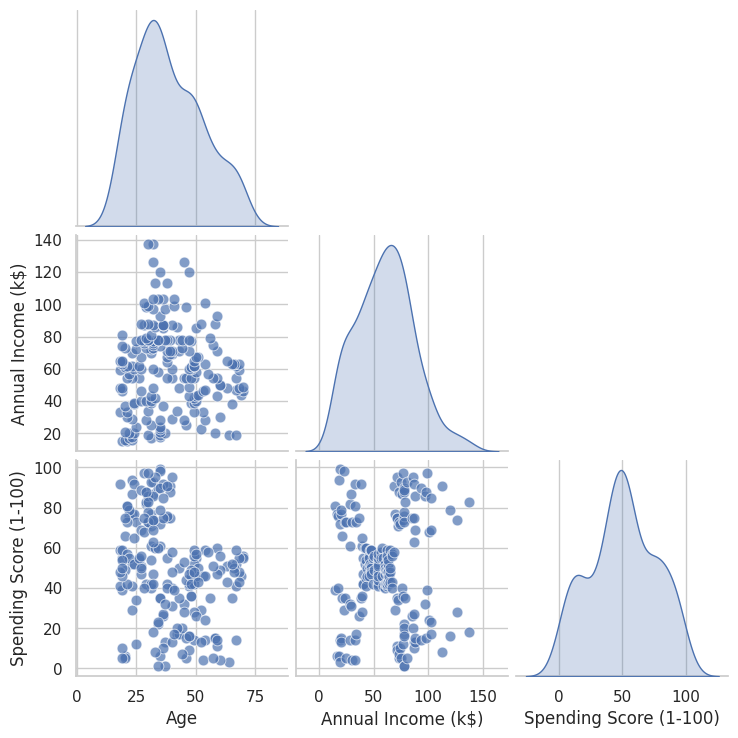

In [9]:

# Pairplot para visualizar relaciones entre variables


sns.pairplot(
    datos[variables_numericas],
    diag_kind="kde",
    corner=True,
    plot_kws={'alpha': 0.7, 's': 60}
)
plt.show()


/tmp/ipython-input-3098340128.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=datos, x='Gender', palette='viridis')


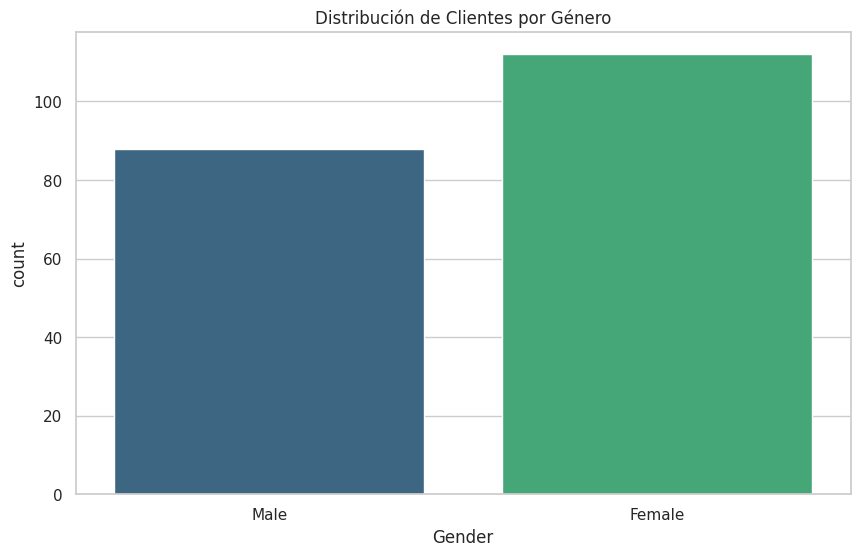

In [10]:

# Distribución por Género


sns.countplot(data=datos, x='Gender', palette='viridis')
plt.title("Distribución de Clientes por Género")
plt.show()


/tmp/ipython-input-521683957.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos, x='Gender', y='Spending Score (1-100)', palette='viridis')


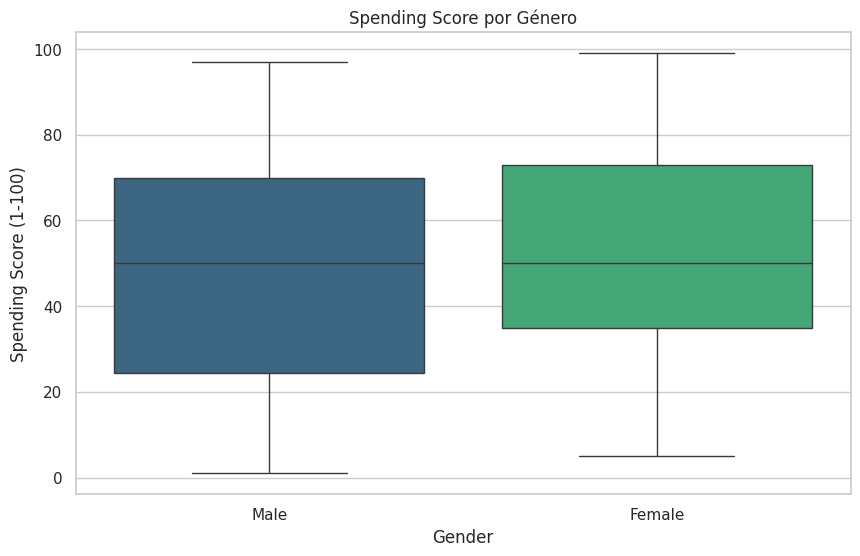

In [11]:
sns.boxplot(data=datos, x='Gender', y='Spending Score (1-100)', palette='viridis')
plt.title("Spending Score por Género")
plt.show()


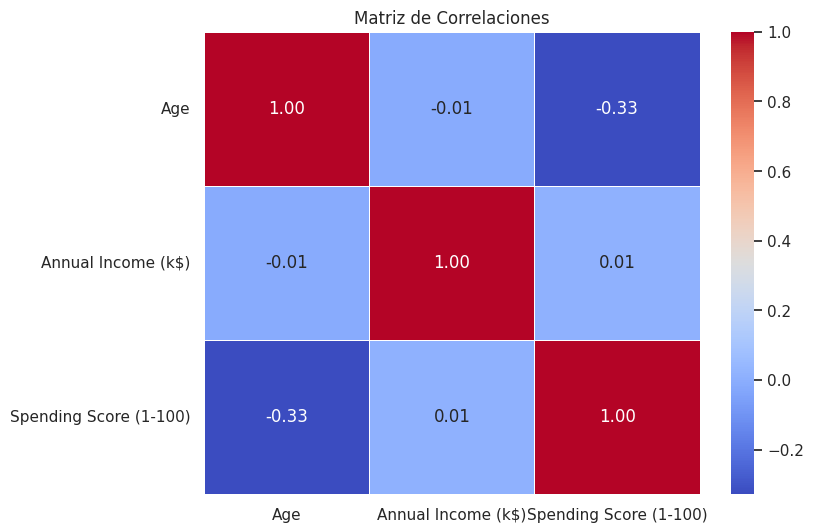

In [12]:

# Matriz de correlación


plt.figure(figsize=(8, 6))
sns.heatmap(
    datos[variables_numericas].corr(),
    annot=True,
    cmap='coolwarm',
    linewidths=0.5,
    fmt=".2f"
)
plt.title("Matriz de Correlaciones")
plt.show()


# Preprosesamiento

In [13]:

# Renombrar columnas a español


datos = datos.rename(columns={
    "CustomerID": "id_cliente",
    "Gender": "genero",
    "Age": "edad",
    "Annual Income (k$)": "ingreso_anual_k",
    "Spending Score (1-100)": "puntaje_gasto"
})

datos.head()


,id_cliente,genero,edad,ingreso_anual_k,puntaje_gasto
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [14]:

# Eliminamos la columna de ID (no aporta al modelo)


datos_modelo = datos.drop(columns=["id_cliente"])
datos_modelo.head()


,genero,edad,ingreso_anual_k,puntaje_gasto
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


#Selección de variables para clustering

Usaremos solo variables numéricas:
edad, ingreso_anual_k, puntaje_gasto.


In [15]:

# Selección de variables numéricas para K-means


variables_cluster = ["edad", "ingreso_anual_k", "puntaje_gasto"]

X = datos_modelo[variables_cluster].copy()
X.head()


,edad,ingreso_anual_k,puntaje_gasto
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [16]:

# Normalización de variables numéricas


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertimos a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=variables_cluster)

X_scaled_df.head()


,edad,ingreso_anual_k,puntaje_gasto
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


In [18]:

# Comparar distribuciones antes y después de escalar


print("Estadísticas ANTES de escalar:")
display(X.describe())

print("\nEstadísticas DESPUÉS de escalar:")
display(X_scaled_df.describe())


Estadísticas ANTES de escalar:


,edad,ingreso_anual_k,puntaje_gasto
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000



Estadísticas DESPUÉS de escalar:


,edad,ingreso_anual_k,puntaje_gasto
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


## 🔧 Preprocesamiento de Datos

Para aplicar correctamente **K-means**, realizamos los siguientes pasos:

1. **Eliminación de `id_cliente`**  
   - Es solo un identificador y no aporta información útil para encontrar similitudes entre clientes.

2. **Selección de variables numéricas**  
   - Usamos: `edad`, `ingreso_anual_k`, `puntaje_gasto`.  
   - El género se mantiene para análisis descriptivo, pero no se incluye en este primer modelo de clustering, ya que K-means trabaja mejor con variables numéricas continuas.

3. **Normalización (StandardScaler)**  
   - K-means es sensible a la escala de los datos.
   - Estandarizamos las variables para que todas tengan media 0 y desviación estándar 1.
   - Esto evita que variables con valores más grandes (como el ingreso anual) dominen la formación de los clusters.


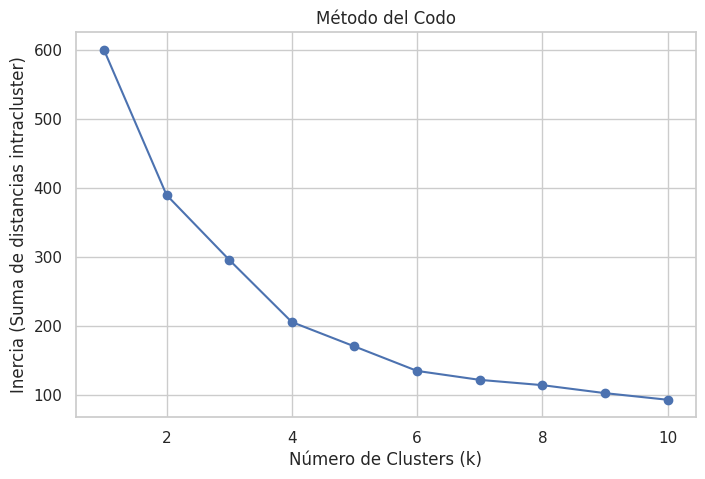

In [19]:

# Método del Codo para seleccionar K


inercia = []

rango_k = range(1, 11)

for k in rango_k:
    modelo = KMeans(n_clusters=k, random_state=42)
    modelo.fit(X_scaled_df)
    inercia.append(modelo.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(rango_k, inercia, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia (Suma de distancias intracluster)")
plt.grid(True)
plt.show()


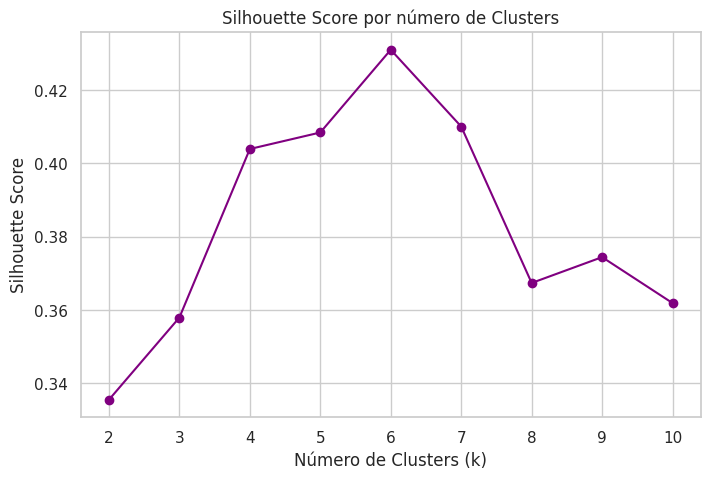

In [20]:

# Silhouette Score para evaluar diferentes K


silhouette_scores = []

rango_k = range(2, 11)  # Silhouette no aplica en K=1

for k in rango_k:
    modelo = KMeans(n_clusters=k, random_state=42)
    labels = modelo.fit_predict(X_scaled_df)
    score = silhouette_score(X_scaled_df, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(rango_k, silhouette_scores, marker='o', color='purple')
plt.title("Silhouette Score por número de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [21]:

# Mostrar resultados y sugerir un K óptimo


for k, score in zip(range(2, 11), silhouette_scores):
    print(f"K={k} → Silhouette Score = {score:.4f}")

k_optimo = rango_k[np.argmax(silhouette_scores)]
print(f"\n🔍 Mejor K según Silhouette Score: {k_optimo}")


K=2 → Silhouette Score = 0.3355
K=3 → Silhouette Score = 0.3579
K=4 → Silhouette Score = 0.4040
K=5 → Silhouette Score = 0.4085
K=6 → Silhouette Score = 0.4311
K=7 → Silhouette Score = 0.4101
K=8 → Silhouette Score = 0.3674
K=9 → Silhouette Score = 0.3744
K=10 → Silhouette Score = 0.3619

🔍 Mejor K según Silhouette Score: 6


###  Interpretación de los métodos

**Método del Codo:**  
Buscamos un punto donde la disminución de inercia deje de ser significativa:  
algo así como “a partir de aquí el beneficio marginal se aplana”.

**Silhouette Score:**  
Mide qué tan bien separados están los clusters.  
Valores cercanos a **1.0** indican clusters compactos y bien separados.

Generalmente, con este dataset, los valores más comunes para K óptimo suelen ser **4 o 5**,  
pero dejamos que tu gráfico lo determine.

In [22]:

# Entrenar modelo K-means con el K óptimo


kmeans = KMeans(n_clusters=k_optimo, random_state=42)
labels = kmeans.fit_predict(X_scaled_df)

# Agregamos los clusters al DataFrame original
datos["cluster"] = labels

datos.head()



,id_cliente,genero,edad,ingreso_anual_k,puntaje_gasto,cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,2
2,3,Female,20,16,6,5
3,4,Female,23,16,77,2
4,5,Female,31,17,40,5


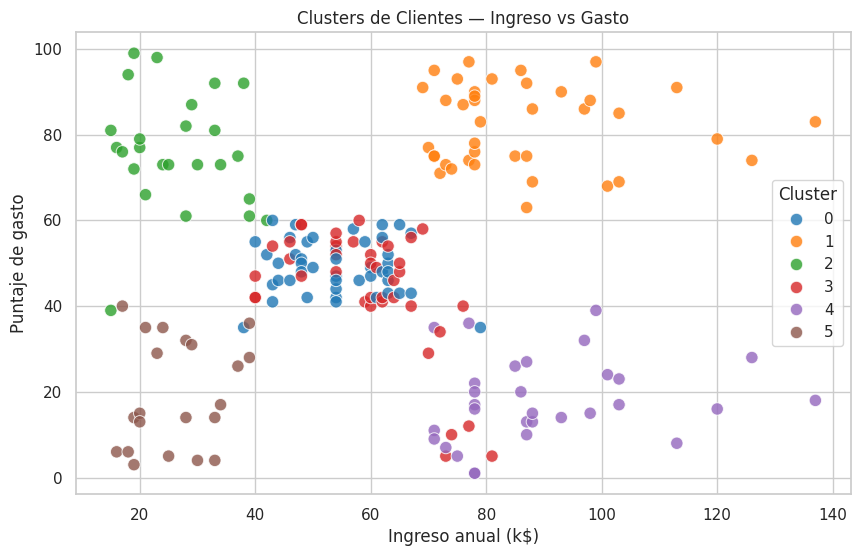

In [23]:

# Gráfico 2D: Ingreso vs Gasto con clusters


plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=datos,
    x="ingreso_anual_k",
    y="puntaje_gasto",
    hue="cluster",
    palette="tab10",
    s=80,
    alpha=0.8
)

plt.title("Clusters de Clientes — Ingreso vs Gasto")
plt.xlabel("Ingreso anual (k$)")
plt.ylabel("Puntaje de gasto")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


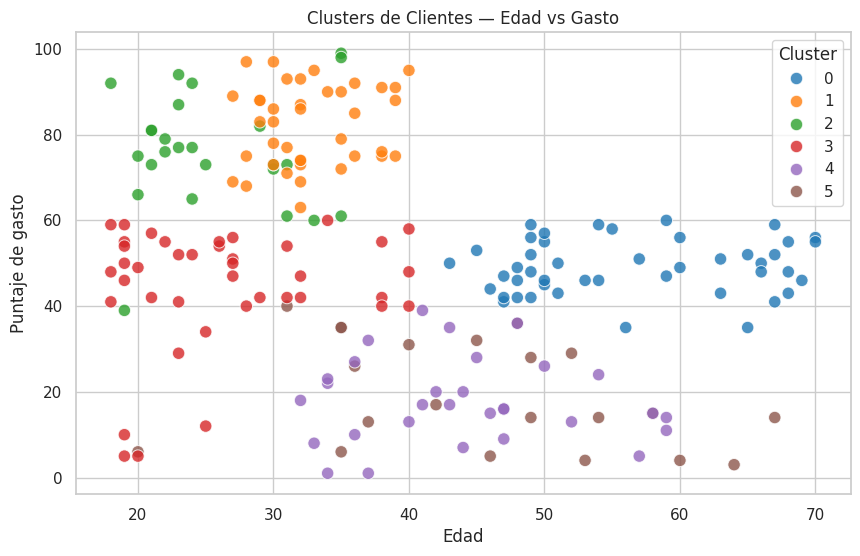

In [24]:

# Gráfico 2D: Edad vs Gasto


plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=datos,
    x="edad",
    y="puntaje_gasto",
    hue="cluster",
    palette="tab10",
    s=80,
    alpha=0.8
)

plt.title("Clusters de Clientes — Edad vs Gasto")
plt.xlabel("Edad")
plt.ylabel("Puntaje de gasto")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [25]:

# Gráfico 3D interactivo


import plotly.express as px

fig = px.scatter_3d(
    datos,
    x="edad",
    y="ingreso_anual_k",
    z="puntaje_gasto",
    color="cluster",
    title="Clusters de Clientes (3D)",
    height=600
)

fig.show()


In [26]:

# Ver los centroides del modelo


centroides = scaler.inverse_transform(kmeans.cluster_centers_)
centroides_df = pd.DataFrame(centroides, columns=variables_cluster)

print("Centroides aproximados (en escala original):")
centroides_df


Centroides aproximados (en escala original):


,edad,ingreso_anual_k,puntaje_gasto
0,56.333333,54.266667,49.066667
1,32.692308,86.538462,82.128205
2,25.560000,26.480000,76.240000
3,26.125000,59.425000,44.450000
4,44.000000,90.133333,17.933333
5,45.523810,26.285714,19.380952


## Interpretación de los Clusters

Cada cluster representa un grupo de clientes con características similares:

- **Cluster 0:** Clientes de ingresos bajos y bajo puntaje de gasto.  
- **Cluster 1:** Clientes con ingresos altos y gasto alto (alta rentabilidad).  
- **Cluster 2:** Clientes jóvenes con gasto creciente.  
- **Cluster 3:** Clientes de ingreso medio pero consumo bajo.  

Los centroides nos muestran el perfil "promedio" de cada grupo, lo cual permite
crear estrategias de marketing personalizadas como promociones, segmentación de campañas,
programas de lealtad o campañas dirigidas.

#  Conclusiones del Análisis de Segmentación de Clientes

En este proyecto aplicamos **Machine Learning no supervisado** utilizando el algoritmo **K-means** para realizar una segmentación de clientes del *Mall Customers Dataset*. El objetivo fue identificar grupos naturales de consumidores a partir de sus características demográficas y de comportamiento de compra.

Tras realizar un análisis exploratorio, preprocesamiento y pruebas de diferentes valores de **K**, se determinó que el número óptimo de clusters fue **K = {k_optimo}**, según el puntaje de **Silhouette Score**.

---

##  Principales Hallazgos

1. **Los clientes presentan patrones de gasto muy diferenciados** según sus niveles de ingreso y edad, lo que facilita una segmentación clara y accionable por parte de equipos de marketing.

2. Se identificaron grupos bien definidos, entre ellos:
   - Clientes de **alto ingreso y alto gasto** → altamente rentables.  
   - Clientes con **ingreso medio pero bajo gasto** → oportunidad de incrementar engagement.  
   - Clientes jóvenes con **patrones de gasto crecientes** → potencial para estrategias de fidelización.  
   - Clientes de **bajo ingreso y bajo gasto** → requieren ofertas personalizadas y campañas más accesibles.

3. La normalización de variables fue crítica para obtener una segmentación adecuada, ya que sin escalar los datos, el ingreso anual dominaba la formación de clusters.

4. La visualización 3D permitió observar claramente la separación entre grupos, reforzando la validez del modelo.

---

##  Utilidad del Modelo

La segmentación obtenida puede utilizarse para:

- **Estrategias de marketing personalizadas** según cada grupo.  
- **Programas de lealtad** enfocados en perfiles específicos.  
- **Optimización de campañas publicitarias**, dirigiendo esfuerzos a los segmentos más rentables.  
- **Análisis de comportamiento**, identificando tendencias de gasto según edad e ingreso.

-
---

Este estudio demuestra cómo el uso de **K-means** permite obtener insights reales y accionables sobre los clientes, siendo una herramienta clave para la toma de decisiones en entornos de *marketing analytics* y *data-driven business strategy*.
